### imports ###

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
from scipy.stats import pearsonr

In [7]:
def source_module(module_file: str, local_module_name: str = None):
    import importlib
    """to add a module from a user defined python script into the local name space"""
    if local_module_name is None:
        local_module_name = module_file.split("/")[-1].replace(".py", "")
    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_file.split("/")[-1].replace(".py", ""))
    g = globals()
    g[local_module_name] = module
    pass

# importing a python script where I keep a lot of the basic functions I use!
source_module("/Users/anjalidhar/Desktop/Packages/mdtools.py")

### figure functions ###

In [1]:
from cycler import cycler
def get_color_list(n_colors: int, cmap: str, trunc=0, pre_trunc=0):
    cmap = getattr(plt.cm, cmap)
    cl = [cmap(i) for i in range(cmap.N)]
    return [cl[i] for i in np.linspace(1 + pre_trunc, len(cl) - 1 - trunc, n_colors).astype(int)]

In [15]:
def load_scores(outdir):
    scores = mdtools.lsdir(outdir, keyword='.npy')
    array = np.stack([np.load(score) for score in scores])
    if len(array.shape) == 3: 
        return array[:, :, :1].squeeze()
    else:
        return array

def plot_score_hist(rundir_pair_list, title, xlim=None): 
    color_list = get_color_list(len(rundir_pair_list[0]), "spring", pre_trunc=50, trunc=30)
    fig, axes = plt.subplots(2,2,figsize = (13,8), sharey = True, sharex = True)

    for i, (ax, rundir_pair) in enumerate(zip(axes.flat, rundir_pair_list)):
        for j, rundir in enumerate(rundir_pair): 
            run_name = rundir.split('/')[-1]
            scores = load_scores(rundir).flatten()
            scores_i = scores[np.where(scores!=0)]
            ax.hist(scores_i, bins=100, histtype="step", linewidth=2,
                    label=fr'{labels[run_name]}, $\bar E$ = {np.mean(scores_i):.2f}', 
                    color=color_list[j], alpha=0.5, density = True)

        ax.legend(fontsize = 5, loc = "upper left", framealpha = .5, prop={'size': 10}) 
        ax.tick_params(labelsize=13)
        if xlim != None: 
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1)
        if i == 0 or i == 2: ax.set_ylabel("Frequency", size = 15)
        if i ==3 or i ==2: ax.set_xlabel("Docking Score (kcal/mol)", size = 15)

    fig.suptitle(f'{title} Docking Scores', size=20)
        

In [12]:
def get_trajtype(name): 
    if 'apo' in name: 
        return 'apo'
    else: 
        return name[-4:]
        
def plot_score_byangle(rundir_list, angledir, dock_program): 
    fig, axes = plt.subplots(2,len(rundir_list)//2,figsize = (12,7), sharey=True, sharex=True)
    color_list = get_color_list(len(rundir_list), "spring", pre_trunc=50, trunc=30)
    
    for color, ax, rundir in zip(color_list, axes.flat, rundir_list):
        run_name = rundir.split('/')[-1]
        type = get_trajtype(run_name)

        # Getting the docking scores and trajectory bend angle of the protein
        scores = load_scores(rundir).mean(1)
        angles = np.load(f'{angledir}/{type}_angles.npy')
        
        # Calculating the lin regression and corr coef
        ndict = mdtools.PolyRegression1D(angles, scores, degree = 1, intercept = True)[0]

        ax.set_title(labels[run_name])
        ax.scatter(angles, scores, color = color, label = rf"$r^{2}$ : {ndict['r2']:.2f}")
        ax.plot(angles, ndict['ypred'], ls = "--", color = "grey")
        ax.legend(loc="upper left")
        
    fig.supxlabel("Bend Angle (degrees)")
    fig.supylabel("Average Docking Score")
    fig.suptitle(f"{dock_program} Scores vs Bend Angles")
    

### Figures! ###

In [23]:
ADrunsdir = '/Users/anjalidhar/Desktop/autodock/docking_scores'
DDrunsdir = '/Users/anjalidhar/Desktop/diffdock/docking_scores'
angledir = '/Users/anjalidhar/Desktop/autodock/trajectory_bendangles'
# The labels that transform my keys into something more accessible
labels = mdtools.load_dict(f'/Users/anjalidhar/Desktop/Packages/run_label_dict')

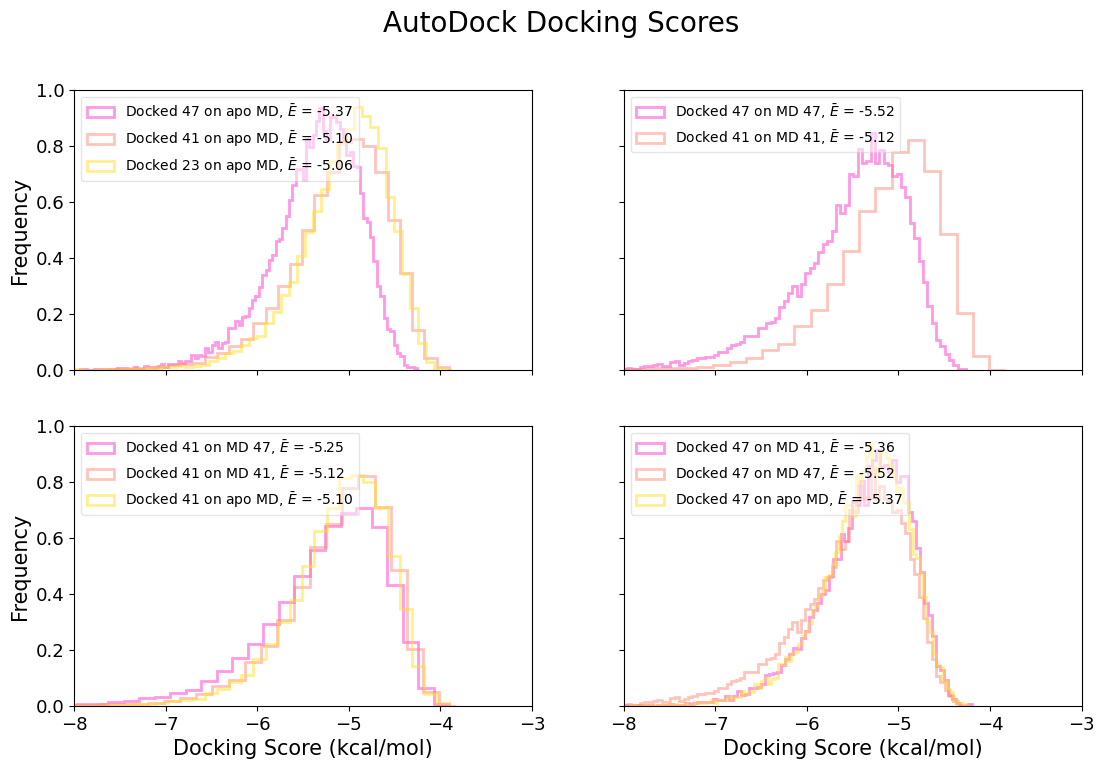

In [18]:
pair_list = [[f'{ADrunsdir}/47onapo', f'{ADrunsdir}/41onapo', f'{ADrunsdir}/23onapo'],
             [f'{ADrunsdir}/47on47bf', f'{ADrunsdir}/41on41bf'], 
            [f'{ADrunsdir}/41on47bf', f'{ADrunsdir}/41on41bf', f'{ADrunsdir}/41onapo'],
            [ f'{ADrunsdir}/47on41bf', f'{ADrunsdir}/47on47bf', f'{ADrunsdir}/47onapo']]
plot_score_hist(pair_list, 'AutoDock', xlim=(-8, -3))

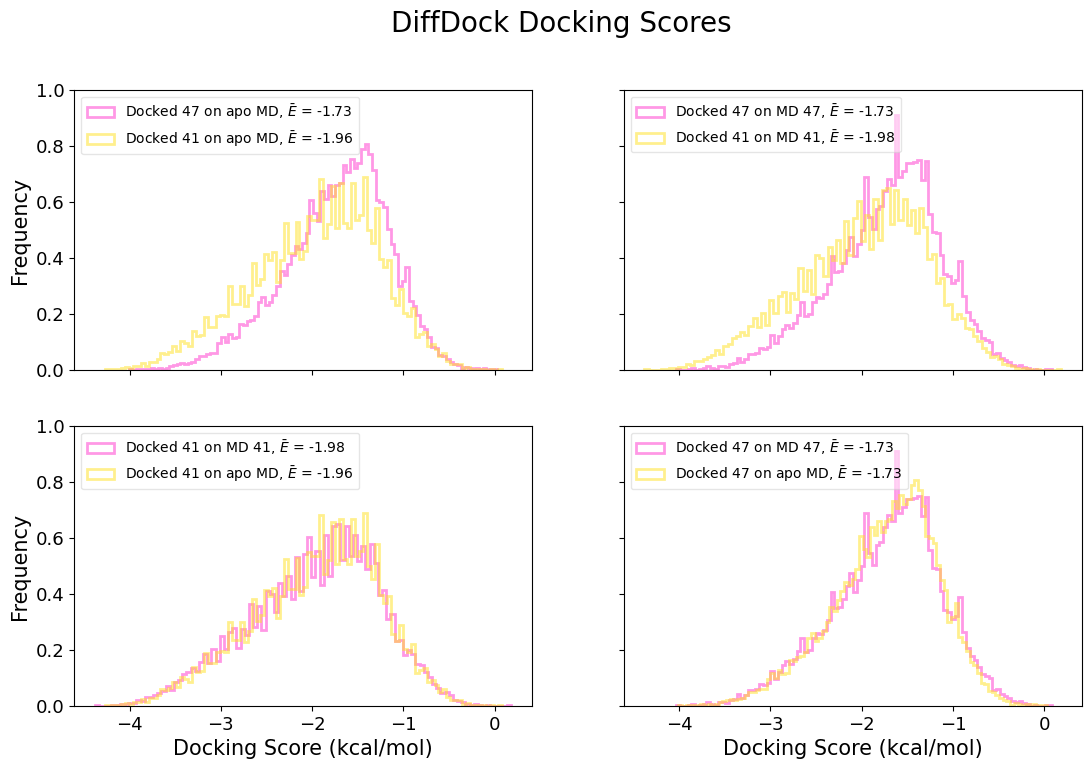

In [19]:
pair_list = [[f'{DDrunsdir}/47onapo', f'{DDrunsdir}/41onapo'],
             [f'{DDrunsdir}/47on47bf', f'{DDrunsdir}/41on41bf'], 
            [f'{DDrunsdir}/41on41bf', f'{DDrunsdir}/41onapo'],
            [f'{DDrunsdir}/47on47bf', f'{DDrunsdir}/47onapo']]
plot_score_hist(pair_list, 'DiffDock')

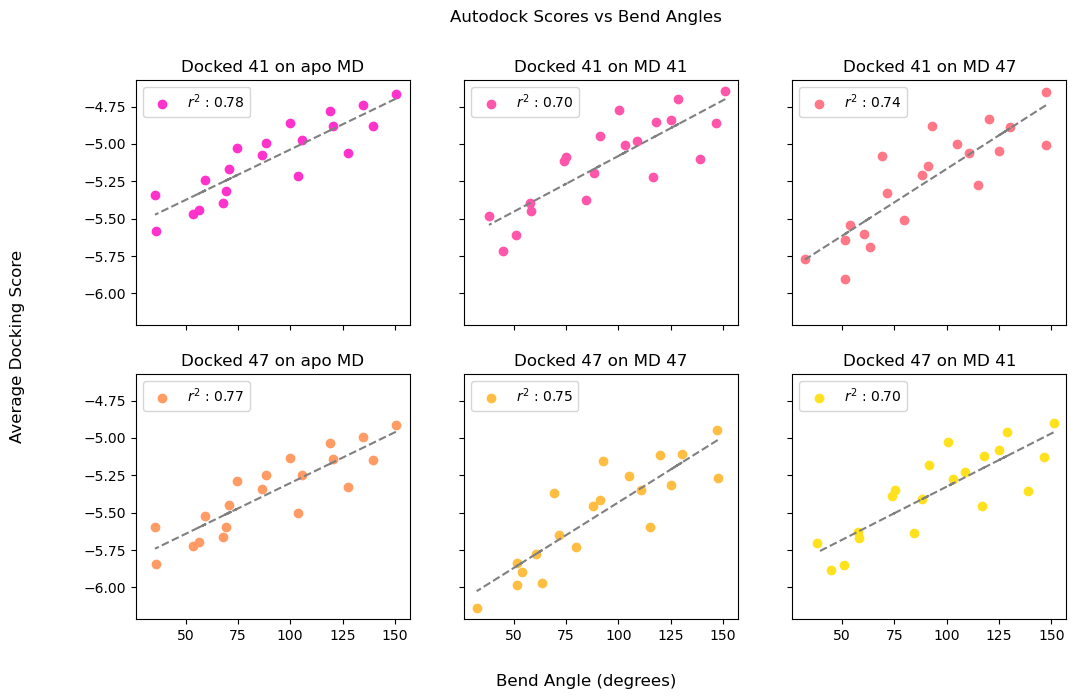

In [13]:
plot_score_byangle([f'{ADrunsdir}/41onapo',f'{ADrunsdir}/41on41bf',f'{ADrunsdir}/41on47bf',
                    f'{ADrunsdir}/47onapo', f'{ADrunsdir}/47on47bf', f'{ADrunsdir}/47on41bf'], angledir, 'Autodock')

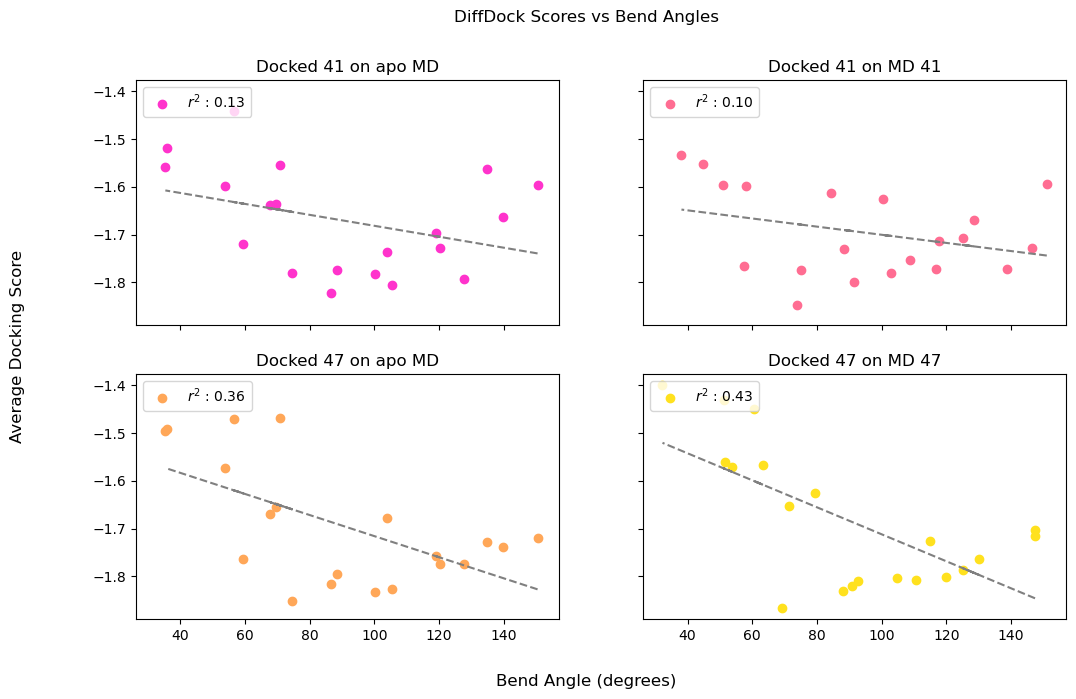

In [14]:
plot_score_byangle([f'{DDrunsdir}/41onapo',f'{DDrunsdir}/41on41bf',
                    f'{DDrunsdir}/47onapo', f'{DDrunsdir}/47on47bf'], angledir, 'DiffDock')